In [227]:
import pandas as pd
from sklearn import linear_model, neighbors, svm, tree, gaussian_process
import shap
import numpy as np
from sklearn.cross_validation import train_test_split
import seaborn as sns
from sklearn.feature_selection import RFE
import time
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

In [486]:
# TODO This is not an ideal form of model selection and is done for exploratory/learning purposes
# TODO This can really be automated if the specific implementations of the models are this basic
accuracy = []

In [487]:
def print_accuracy(f):
    print("Accuracy = {0}%".format(100*np.sum(f(X_test) == y_test)/len(y_test)))
    time.sleep(0.5) # to let the print get out before any progress bars

def gen_kfold(modelCV, X_train, y_train, additional_label = ''):
    kfold = model_selection.KFold(n_splits=10, random_state=7)
    scoring = 'accuracy'
    results = model_selection.cross_val_score(modelCV, X_train, y_train, cv=kfold, scoring=scoring)
    accuracy.append((modelCV.__class__.__name__ + additional_label, results.mean()))
    print("10-fold cross validation average accuracy: %.3f" % (results.mean()))

def gen_confusion(model, X_test): 
    y_pred = model.predict(X_test)
    print('Accuracy of ' + model.__class__.__name__ + 'classifier on test set: {:.2f}'.format(model.score(X_test, y_test)))
    from sklearn.metrics import confusion_matrix
    confusion_matrix = confusion_matrix(y_test, y_pred)
    print(confusion_matrix)

In [488]:
main = pd.read_csv('data.csv')

In [489]:
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [490]:
main = main.drop("Unnamed: 32", axis=1)

In [491]:
main['diagnosis'].unique()

array(['M', 'B'], dtype=object)

In [492]:
main.ix[main.diagnosis == 'M', 'diagnosis'] = 1
main.ix[main.diagnosis == 'B', 'diagnosis'] = 0

/Users/BekkBlando/Documents/github/wisconsin_data/.direnv/python-3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


In [493]:
def gen_rfe(model):
    rfe = RFE(model)
    rfe = rfe.fit(main[X], main[y])
    print(list(zip(X, rfe.ranking_, rfe.support_)))
    print(rfe.estimator)
    table = pd.DataFrame({
        'Ranking': rfe.ranking_,
        'Included': rfe.support_,
        'Feature': X
    })
    print(table)
    return(rfe.support_)

In [494]:
col_order = gen_rfe(logistic)

[('radius_mean', 1, True), ('texture_mean', 1, True), ('perimeter_mean', 2, False), ('area_mean', 16, False), ('smoothness_mean', 3, False), ('compactness_mean', 7, False), ('concavity_mean', 1, True), ('concave points_mean', 1, True), ('symmetry_mean', 1, True), ('fractal_dimension_mean', 12, False), ('radius_se', 11, False), ('texture_se', 1, True), ('perimeter_se', 1, True), ('area_se', 1, True), ('smoothness_se', 13, False), ('compactness_se', 14, False), ('concavity_se', 4, False), ('concave points_se', 9, False), ('symmetry_se', 8, False), ('fractal_dimension_se', 15, False), ('radius_worst', 1, True), ('texture_worst', 1, True), ('perimeter_worst', 1, True), ('area_worst', 10, False), ('smoothness_worst', 5, False), ('compactness_worst', 1, True), ('concavity_worst', 1, True), ('concave points_worst', 1, True), ('symmetry_worst', 6, False), ('fractal_dimension_worst', 1, True)]
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scali

/Users/BekkBlando/Documents/github/wisconsin_data/.direnv/python-3.6.5/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [495]:
def get_train_test_data(model):
    final_cols = main.columns.values.tolist()
    y = ['diagnosis']
    exclude = ['diagnosis', 'id']
    X = [col for col in final_cols if col not in exclude]
    picked_features = gen_rfe(model)
    cols = [col for index, col in enumerate(X) if picked_features[index]]
    X = main[cols]
    y = main['diagnosis']
    return(train_test_split(X, y, test_size=0.3, random_state=0))

In [496]:
def plot_coef_feature(coefs):
    print(list(zip(cols, coefs)))
    plt.bar(np.arange(len(coefs)), coefs, align='center', alpha=0.5)
    plt.xticks(np.arange(len(coefs)), cols, rotation='vertical')
    plt.ylabel('Coefficient')
    plt.title('Feature')
    plt.figure(num=None, figsize=(80, 60), dpi=80, facecolor='w', edgecolor='k')

/Users/BekkBlando/Documents/github/wisconsin_data/.direnv/python-3.6.5/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[('radius_mean', 1, True), ('texture_mean', 1, True), ('perimeter_mean', 3, False), ('area_mean', 16, False), ('smoothness_mean', 4, False), ('compactness_mean', 8, False), ('concavity_mean', 1, True), ('concave points_mean', 1, True), ('symmetry_mean', 1, True), ('fractal_dimension_mean', 12, False), ('radius_se', 1, True), ('texture_se', 1, True), ('perimeter_se', 1, True), ('area_se', 1, True), ('smoothness_se', 13, False), ('compactness_se', 15, False), ('concavity_se', 5, False), ('concave points_se', 10, False), ('symmetry_se', 9, False), ('fractal_dimension_se', 14, False), ('radius_worst', 1, True), ('texture_worst', 1, True), ('perimeter_worst', 1, True), ('area_worst', 11, False), ('smoothness_worst', 6, False), ('compactness_worst', 1, True), ('concavity_worst', 1, True), ('concave points_worst', 1, True), ('symmetry_worst', 7, False), ('fractal_dimension_worst', 2, False)]
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scali

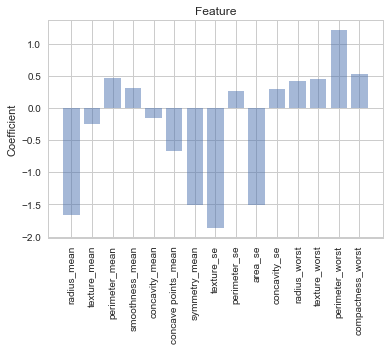

<Figure size 6400x4800 with 0 Axes>

In [497]:
from sklearn import metrics
X_train, X_test, y_train, y_test = get_train_test_data(linear_model.LogisticRegression())
logreg = linear_model.LogisticRegression()
logreg.fit(X_train, y_train)
gen_confusion(logreg, X_test)
gen_kfold(linear_model.LogisticRegression(), X_train, y_train)
plot_coef_feature(logreg.coef_[0])

In [498]:
# Time for K Means
knn = neighbors.KNeighborsClassifier()
knn.fit(X_train, y_train)

print_accuracy(knn.predict)

gen_confusion(knn, X_test)
gen_kfold(neighbors.KNeighborsClassifier(), X_train, y_train)

Accuracy = 95.90643274853801%
Accuracy of KNeighborsClassifierclassifier on test set: 0.96
[[103   5]
 [  2  61]]
10-fold cross validation average accuracy: 0.932


In [499]:
# SVM Time - Radial Kernal
svc_radial = svm.SVC(kernel='rbf', probability=True)
svc_radial.fit(X_train, y_train)
print_accuracy(svc_radial.predict)

gen_confusion(svc_radial, X_test)
gen_kfold(svm.SVC(kernel='rbf', probability=True), X_train, y_train, "Radial Kernal")

# TODO Generate these graphs
# shap_values = shap.KernelExplainer(svc_radial.predict_proba, X_train).shap_values(X_test)
# shap.force_plot(shap_values[0], X_test)

Accuracy = 90.64327485380117%
Accuracy of SVCclassifier on test set: 0.91
[[95 13]
 [ 3 60]]
10-fold cross validation average accuracy: 0.884


In [500]:
# SVM Time - Sigmoid Kernal
svc_sigmoid = svm.SVC(kernel='sigmoid', probability=True)
svc_sigmoid.fit(X_train, y_train)
print_accuracy(svc_sigmoid.predict)

gen_confusion(svc_sigmoid, X_test)
gen_kfold(svm.SVC(kernel='sigmoid', probability=True), X_train, y_train, "Sigmoid Kernal")

# TODO Generate these graphs
# shap_values = shap.KernelExplainer(svc_sigmoid.predict_proba, X_train).shap_values(X_test)
# shap.force_plot(shap_values[0], X_test)

Accuracy = 63.1578947368421%
Accuracy of SVCclassifier on test set: 0.63
[[108   0]
 [ 63   0]]
10-fold cross validation average accuracy: 0.625


In [501]:
# SVM Time - Polynomial Kernal
svc_poly = svm.SVC(kernel='poly', probability=True)
svc_poly.fit(X_train, y_train)
print_accuracy(svc_poly.predict)

gen_confusion(svc_poly, X_test)
gen_kfold(svm.SVC(kernel='poly', probability=True), X_train, y_train, "Polynomial Kernal")

# TODO Generate these graphs
# shap_values = shap.KernelExplainer(svc_linear.predict_proba, X_train).shap_values(X_test)
# shap.force_plot(shap_values[0], X_test)

Accuracy = 93.5672514619883%
Accuracy of SVCclassifier on test set: 0.94
[[98 10]
 [ 1 62]]
10-fold cross validation average accuracy: 0.952


In [502]:
# SVM Time - Linear Kernal
svc_linear = svm.SVC(kernel='linear', probability=True)
svc_linear.fit(X_train, y_train)
print_accuracy(svc_linear.predict)


gen_confusion(svc_linear, X_test)
gen_kfold(svm.SVC(kernel='linear', probability=True), X_train, y_train, "Linear Kernal")

# TODO Generate these graphs
# shap_values = shap.KernelExplainer(svc_linear.predict_proba, X_train).shap_values(X_test)
# shap.force_plot(shap_values[0], X_test)

Accuracy = 95.90643274853801%
Accuracy of SVCclassifier on test set: 0.96
[[102   6]
 [  1  62]]
10-fold cross validation average accuracy: 0.947


/Users/BekkBlando/Documents/github/wisconsin_data/.direnv/python-3.6.5/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[('radius_mean', 1, True), ('texture_mean', 1, True), ('perimeter_mean', 1, True), ('area_mean', 1, True), ('smoothness_mean', 3, False), ('compactness_mean', 8, False), ('concavity_mean', 1, True), ('concave points_mean', 1, True), ('symmetry_mean', 14, False), ('fractal_dimension_mean', 16, False), ('radius_se', 7, False), ('texture_se', 10, False), ('perimeter_se', 4, False), ('area_se', 1, True), ('smoothness_se', 13, False), ('compactness_se', 12, False), ('concavity_se', 9, False), ('concave points_se', 11, False), ('symmetry_se', 15, False), ('fractal_dimension_se', 6, False), ('radius_worst', 1, True), ('texture_worst', 1, True), ('perimeter_worst', 1, True), ('area_worst', 1, True), ('smoothness_worst', 1, True), ('compactness_worst', 2, False), ('concavity_worst', 1, True), ('concave points_worst', 1, True), ('symmetry_worst', 1, True), ('fractal_dimension_worst', 5, False)]
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None

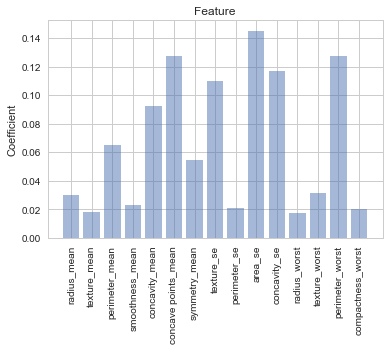

<Figure size 6400x4800 with 0 Axes>

In [503]:
# Random Forest Time
from sklearn.ensemble import RandomForestClassifier
X_train, X_test, y_train, y_test = get_train_test_data(RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=0))
rforest = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=0)
rforest.fit(X_train, y_train)
print_accuracy(rforest.predict)

gen_confusion(rforest, X_test)
gen_kfold(RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=0), X_train, y_train)

# TODO Generate these graphs
# shap_values = shap.KernelExplainer(rforest.predict_proba, X_train).shap_values(X_test)
# shap.force_plot(shap_values[0], X_test)
plot_coef_feature(rforest.feature_importances_)

/Users/BekkBlando/Documents/github/wisconsin_data/.direnv/python-3.6.5/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[('radius_mean', 16, False), ('texture_mean', 12, False), ('perimeter_mean', 10, False), ('area_mean', 11, False), ('smoothness_mean', 9, False), ('compactness_mean', 8, False), ('concavity_mean', 6, False), ('concave points_mean', 1, True), ('symmetry_mean', 3, False), ('fractal_dimension_mean', 2, False), ('radius_se', 1, True), ('texture_se', 1, True), ('perimeter_se', 1, True), ('area_se', 1, True), ('smoothness_se', 1, True), ('compactness_se', 15, False), ('concavity_se', 4, False), ('concave points_se', 7, False), ('symmetry_se', 1, True), ('fractal_dimension_se', 1, True), ('radius_worst', 1, True), ('texture_worst', 1, True), ('perimeter_worst', 13, False), ('area_worst', 1, True), ('smoothness_worst', 1, True), ('compactness_worst', 1, True), ('concavity_worst', 1, True), ('concave points_worst', 1, True), ('symmetry_worst', 5, False), ('fractal_dimension_worst', 14, False)]
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=N

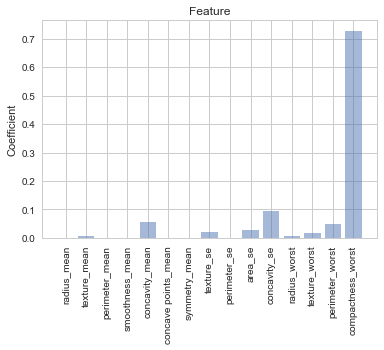

<Figure size 6400x4800 with 0 Axes>

In [504]:
# Decision Tree Time
X_train, X_test, y_train, y_test = get_train_test_data(tree.DecisionTreeClassifier(min_samples_split=2))
dtree = tree.DecisionTreeClassifier(min_samples_split=2)
dtree.fit(X_train, y_train)
print_accuracy(dtree.predict)

gen_confusion(dtree, X_test)
gen_kfold(tree.DecisionTreeClassifier(min_samples_split=2), X_train, y_train)


# TODO Generate these graphs
# shap_values = shap.KernelExplainer(dtree.predict_proba, X_train).shap_values(X_test)
# shap.force_plot(shap_values[0], X_test)
plot_coef_feature(dtree.feature_importances_)

In [505]:
# Simple Neural Net
from sklearn.neural_network import MLPClassifier
nn = MLPClassifier(solver='lbfgs', alpha=1e-1, hidden_layer_sizes=(5, 2), random_state=0)
nn.fit(X_train, y_train)
print_accuracy(nn.predict)

gen_confusion(nn, X_test)
gen_kfold(MLPClassifier(solver='lbfgs', alpha=1e-1, hidden_layer_sizes=(5, 2), random_state=0), X_train, y_train)

# explain all the predictions in the test set
# shap_values = shap.KernelExplainer(nn.predict_proba, X_train).shap_values(X_test)
# shap.force_plot(shap_values[0], X_test)

Accuracy = 95.32163742690058%
Accuracy of MLPClassifierclassifier on test set: 0.95
[[103   5]
 [  3  60]]
10-fold cross validation average accuracy: 0.832


In [506]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)
print_accuracy(gnb.predict)

gen_confusion(gnb, X_test)
gen_kfold(GaussianNB(), X_train, y_train)
# shap_values = shap.KernelExplainer(gnb.predict_proba, X_train).shap_values(X_test)
# shap.force_plot(shap_values[0], X_test)

Accuracy = 91.81286549707602%
Accuracy of GaussianNBclassifier on test set: 0.92
[[101   7]
 [  7  56]]
10-fold cross validation average accuracy: 0.947


[('radius_mean', 1, True), ('texture_mean', 1, True), ('perimeter_mean', 1, True), ('area_mean', 1, True), ('smoothness_mean', 2, False), ('compactness_mean', 8, False), ('concavity_mean', 1, True), ('concave points_mean', 7, False), ('symmetry_mean', 1, True), ('fractal_dimension_mean', 3, False), ('radius_se', 9, False), ('texture_se', 1, True), ('perimeter_se', 10, False), ('area_se', 1, True), ('smoothness_se', 14, False), ('compactness_se', 12, False), ('concavity_se', 11, False), ('concave points_se', 16, False), ('symmetry_se', 13, False), ('fractal_dimension_se', 15, False), ('radius_worst', 1, True), ('texture_worst', 1, True), ('perimeter_worst', 1, True), ('area_worst', 1, True), ('smoothness_worst', 1, True), ('compactness_worst', 5, False), ('concavity_worst', 1, True), ('concave points_worst', 6, False), ('symmetry_worst', 1, True), ('fractal_dimension_worst', 4, False)]
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_interc

/Users/BekkBlando/Documents/github/wisconsin_data/.direnv/python-3.6.5/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy of SGDClassifierclassifier on test set: 0.85
[[87 21]
 [ 4 59]]
10-fold cross validation average accuracy: 0.805
[('radius_mean', -2850.769479993504), ('texture_mean', -4597.116474971627), ('perimeter_mean', -16563.12975862619), ('smoothness_mean', -8965.17090555641), ('concavity_mean', 51.392074518062415), ('concave points_mean', -46.684108213186256), ('symmetry_mean', -341.93406771423844), ('texture_se', 8379.04422485011), ('perimeter_se', -2942.8592256601255), ('area_se', -5785.177385387961), ('concavity_se', -16376.591608618108), ('radius_worst', 11707.111615097947), ('texture_worst', -30.680074518062348), ('perimeter_worst', 105.56823748582508), ('compactness_worst', -62.60084237809786)]


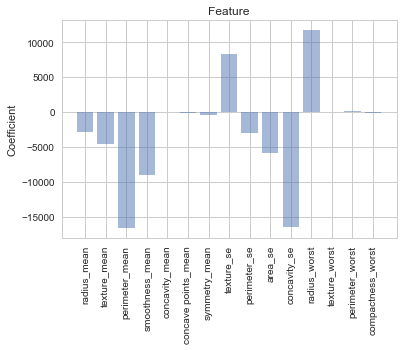

<Figure size 6400x4800 with 0 Axes>

In [507]:
# SGD Classifier
X_train, X_test, y_train, y_test = get_train_test_data(linear_model.SGDClassifier(max_iter=30, tol=1e-3))
clf = linear_model.SGDClassifier(max_iter=30, tol=1e-3)
clf.fit(X_train, y_train)

print_accuracy(clf.predict)

gen_confusion(clf, X_test)
gen_kfold(linear_model.SGDClassifier(max_iter=100, tol=1e-3), X_train, y_train)
plot_coef_feature(clf.coef_[0])

/Users/BekkBlando/Documents/github/wisconsin_data/.direnv/python-3.6.5/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[('radius_mean', 1, True), ('texture_mean', 1, True), ('perimeter_mean', 1, True), ('area_mean', 1, True), ('smoothness_mean', 2, False), ('compactness_mean', 13, False), ('concavity_mean', 1, True), ('concave points_mean', 6, False), ('symmetry_mean', 1, True), ('fractal_dimension_mean', 3, False), ('radius_se', 9, False), ('texture_se', 1, True), ('perimeter_se', 8, False), ('area_se', 1, True), ('smoothness_se', 11, False), ('compactness_se', 16, False), ('concavity_se', 12, False), ('concave points_se', 15, False), ('symmetry_se', 10, False), ('fractal_dimension_se', 14, False), ('radius_worst', 1, True), ('texture_worst', 1, True), ('perimeter_worst', 1, True), ('area_worst', 1, True), ('smoothness_worst', 1, True), ('compactness_worst', 5, False), ('concavity_worst', 1, True), ('concave points_worst', 7, False), ('symmetry_worst', 1, True), ('fractal_dimension_worst', 4, False)]
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=1, fit_intercep

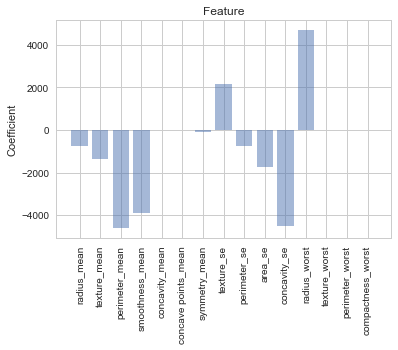

<Figure size 6400x4800 with 0 Axes>

In [508]:
# Perceptron
iteration = 10
X_train, X_test, y_train, y_test = get_train_test_data(linear_model.SGDClassifier(loss="perceptron", eta0=1, learning_rate="constant", penalty=None, max_iter=iteration, tol=1e-3))
clf = linear_model.SGDClassifier(loss="perceptron", eta0=1, learning_rate="constant", penalty=None, max_iter=iteration, tol=1e-3)
clf.fit(X_train, y_train)

print_accuracy(clf.predict)

gen_confusion(clf, X_test)
gen_kfold(linear_model.SGDClassifier(loss="perceptron", eta0=1, learning_rate="constant", penalty=None, max_iter=iteration, tol=1e-3), X_train, y_train)
plot_coef_feature(clf.coef_[0])

Computing regularization path using the LARS ...
.

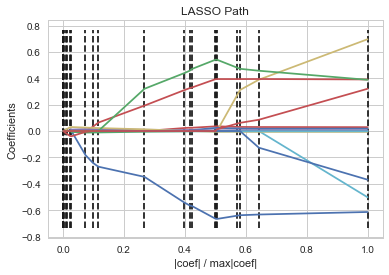

In [509]:

print("Computing regularization path using the LARS ...")
alphas, _, coefs = linear_model.lars_path(X_train.as_matrix(), y_train, method='lasso', verbose=True)

xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.show()

In [521]:
# Radius Neighbors Classifier
radius = 1000
rnc = neighbors.RadiusNeighborsClassifier(radius = radius)
rnc.fit(X_train, y_train)

print_accuracy(rnc.predict)

gen_confusion(rnc, X_test)
gen_kfold(neighbors.RadiusNeighborsClassifier(radius = radius), X_train, y_train)

Accuracy = 79.53216374269006%
Accuracy of RadiusNeighborsClassifierclassifier on test set: 0.80
[[108   0]
 [ 35  28]]


ValueError: No neighbors found for test samples [33], you can try using larger radius, give a label for outliers, or consider removing them from your dataset.

In [523]:
# Neartest Shrunken Centroid
clf = neighbors.NearestCentroid(shrink_threshold=.1)
clf.fit(X_train, y_train)

print_accuracy(clf.predict)

gen_confusion(clf, X_test)
gen_kfold(neighbors.NearestCentroid(shrink_threshold=.1), X_train, y_train)

Accuracy = 90.05847953216374%
Accuracy of NearestCentroidclassifier on test set: 0.90
[[107   1]
 [ 16  47]]
10-fold cross validation average accuracy: 0.884


In [524]:
# Gaussian Process Classifier - 1.0 * RBF(1.0)
gausc = gaussian_process.GaussianProcessClassifier()
gausc.fit(X_train, y_train)

print_accuracy(gausc.predict)

gen_confusion(gausc, X_test)
gen_kfold(gaussian_process.GaussianProcessClassifier(), X_train, y_train)

Accuracy = 73.6842105263158%
Accuracy of GaussianProcessClassifierclassifier on test set: 0.74
[[101   7]
 [ 38  25]]
10-fold cross validation average accuracy: 0.719


[('radius_mean', 7, False), ('texture_mean', 14, False), ('perimeter_mean', 8, False), ('area_mean', 16, False), ('smoothness_mean', 1, True), ('compactness_mean', 1, True), ('concavity_mean', 2, False), ('concave points_mean', 1, True), ('symmetry_mean', 1, True), ('fractal_dimension_mean', 1, True), ('radius_se', 1, True), ('texture_se', 11, False), ('perimeter_se', 4, False), ('area_se', 13, False), ('smoothness_se', 1, True), ('compactness_se', 1, True), ('concavity_se', 1, True), ('concave points_se', 1, True), ('symmetry_se', 3, False), ('fractal_dimension_se', 6, False), ('radius_worst', 5, False), ('texture_worst', 10, False), ('perimeter_worst', 12, False), ('area_worst', 15, False), ('smoothness_worst', 1, True), ('compactness_worst', 9, False), ('concavity_worst', 1, True), ('concave points_worst', 1, True), ('symmetry_worst', 1, True), ('fractal_dimension_worst', 1, True)]
LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd',

/Users/BekkBlando/Documents/github/wisconsin_data/.direnv/python-3.6.5/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy of LinearDiscriminantAnalysisclassifier on test set: 0.93
[[107   1]
 [ 11  52]]
10-fold cross validation average accuracy: 0.947
[('radius_mean', -23.76251802544825), ('texture_mean', -29.17224469442914), ('perimeter_mean', 71.96255314769543), ('smoothness_mean', 4.707948315500397), ('concavity_mean', -249.10410617256343), ('concave points_mean', 5.12093052607813), ('symmetry_mean', 104.27790181434372), ('texture_se', -24.97809342178919), ('perimeter_se', -39.52251683366005), ('area_se', 91.36759450349142), ('concavity_se', 27.654129276978487), ('radius_worst', 11.243482525873265), ('texture_worst', 22.293601344041896), ('perimeter_worst', 11.956413461729348), ('compactness_worst', 73.76242687179172)]


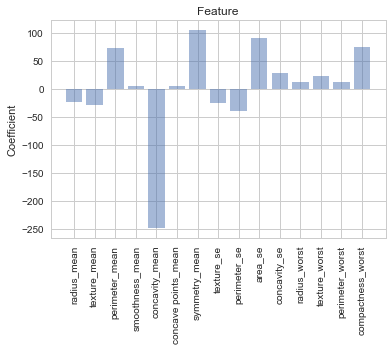

<Figure size 6400x4800 with 0 Axes>

In [525]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# Linear Discriminant Analysis
X_train, X_test, y_train, y_test = get_train_test_data(LinearDiscriminantAnalysis())
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

print_accuracy(lda.predict)

gen_confusion(lda, X_test)
gen_kfold(LinearDiscriminantAnalysis(), X_train, y_train)
plot_coef_feature(lda.coef_[0])

/Users/BekkBlando/Documents/github/wisconsin_data/.direnv/python-3.6.5/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[('radius_mean', 1, True), ('texture_mean', 1, True), ('perimeter_mean', 1, True), ('area_mean', 1, True), ('smoothness_mean', 4, False), ('compactness_mean', 16, False), ('concavity_mean', 1, True), ('concave points_mean', 1, True), ('symmetry_mean', 14, False), ('fractal_dimension_mean', 6, False), ('radius_se', 2, False), ('texture_se', 12, False), ('perimeter_se', 11, False), ('area_se', 1, True), ('smoothness_se', 8, False), ('compactness_se', 5, False), ('concavity_se', 9, False), ('concave points_se', 7, False), ('symmetry_se', 10, False), ('fractal_dimension_se', 15, False), ('radius_worst', 1, True), ('texture_worst', 1, True), ('perimeter_worst', 1, True), ('area_worst', 1, True), ('smoothness_worst', 3, False), ('compactness_worst', 1, True), ('concavity_worst', 1, True), ('concave points_worst', 1, True), ('symmetry_worst', 1, True), ('fractal_dimension_worst', 13, False)]
ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, 

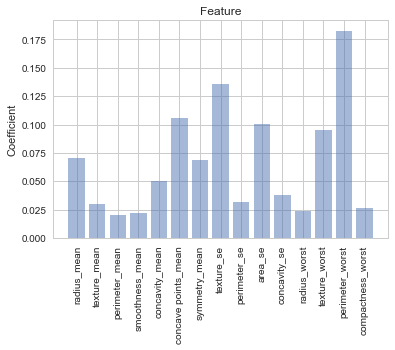

<Figure size 6400x4800 with 0 Axes>

In [526]:
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
# Extra Trees Classifier
X_train, X_test, y_train, y_test = get_train_test_data(ExtraTreesClassifier())
etc = ExtraTreesClassifier()
etc.fit(X_train, y_train)

print_accuracy(etc.predict)

gen_confusion(etc, X_test)
gen_kfold(ExtraTreesClassifier(), X_train, y_train)
plot_coef_feature(etc.feature_importances_)

/Users/BekkBlando/Documents/github/wisconsin_data/.direnv/python-3.6.5/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[('radius_mean', 8, False), ('texture_mean', 1, True), ('perimeter_mean', 1, True), ('area_mean', 1, True), ('smoothness_mean', 14, False), ('compactness_mean', 1, True), ('concavity_mean', 10, False), ('concave points_mean', 1, True), ('symmetry_mean', 7, False), ('fractal_dimension_mean', 16, False), ('radius_se', 2, False), ('texture_se', 9, False), ('perimeter_se', 12, False), ('area_se', 1, True), ('smoothness_se', 3, False), ('compactness_se', 5, False), ('concavity_se', 4, False), ('concave points_se', 11, False), ('symmetry_se', 15, False), ('fractal_dimension_se', 1, True), ('radius_worst', 1, True), ('texture_worst', 1, True), ('perimeter_worst', 1, True), ('area_worst', 1, True), ('smoothness_worst', 1, True), ('compactness_worst', 1, True), ('concavity_worst', 1, True), ('concave points_worst', 1, True), ('symmetry_worst', 6, False), ('fractal_dimension_worst', 13, False)]
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss=

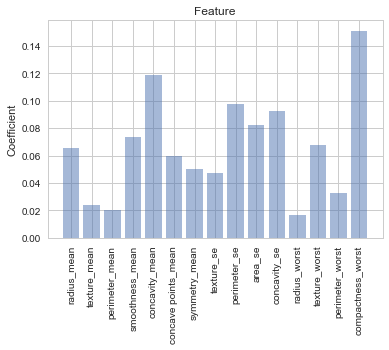

<Figure size 6400x4800 with 0 Axes>

In [527]:
# Gradient Boosting Classifier
X_train, X_test, y_train, y_test = get_train_test_data(GradientBoostingClassifier())
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)

print_accuracy(gbc.predict)

gen_confusion(gbc, X_test)
gen_kfold(GradientBoostingClassifier(), X_train, y_train)
plot_coef_feature(gbc.feature_importances_)

In [528]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
# Quadrati Discriminant Analysis
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)

print_accuracy(qda.predict)

gen_confusion(qda, X_test)
gen_kfold(QuadraticDiscriminantAnalysis(), X_train, y_train)

Accuracy = 96.49122807017544%
Accuracy of QuadraticDiscriminantAnalysisclassifier on test set: 0.96
[[105   3]
 [  3  60]]
10-fold cross validation average accuracy: 0.950


/Users/BekkBlando/Documents/github/wisconsin_data/.direnv/python-3.6.5/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[('radius_mean', 16, False), ('texture_mean', 1, True), ('perimeter_mean', 14, False), ('area_mean', 12, False), ('smoothness_mean', 2, False), ('compactness_mean', 1, True), ('concavity_mean', 1, True), ('concave points_mean', 1, True), ('symmetry_mean', 10, False), ('fractal_dimension_mean', 15, False), ('radius_se', 5, False), ('texture_se', 3, False), ('perimeter_se', 9, False), ('area_se', 1, True), ('smoothness_se', 8, False), ('compactness_se', 1, True), ('concavity_se', 13, False), ('concave points_se', 11, False), ('symmetry_se', 4, False), ('fractal_dimension_se', 1, True), ('radius_worst', 1, True), ('texture_worst', 1, True), ('perimeter_worst', 6, False), ('area_worst', 1, True), ('smoothness_worst', 1, True), ('compactness_worst', 1, True), ('concavity_worst', 1, True), ('concave points_worst', 1, True), ('symmetry_worst', 1, True), ('fractal_dimension_worst', 7, False)]
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators

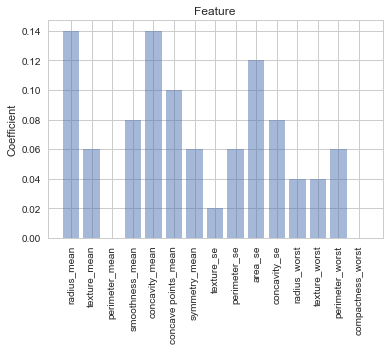

<Figure size 6400x4800 with 0 Axes>

In [529]:
# Ada Classifier
X_train, X_test, y_train, y_test = get_train_test_data(AdaBoostClassifier())
ada = AdaBoostClassifier()
ada.fit(X_train, y_train)

print_accuracy(ada.predict)

gen_confusion(ada, X_test)
gen_kfold(AdaBoostClassifier(), X_train, y_train)
plot_coef_feature(ada.feature_importances_)

In [530]:
labels = [pair[0] for pair in accuracy]
acc = [pair[1] for pair in accuracy]
y_pos = np.arange(len(acc))

<Figure size 6400x4800 with 0 Axes>

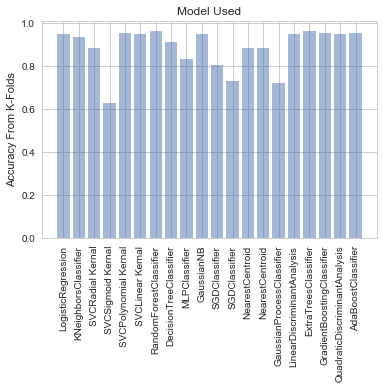

<Figure size 6400x4800 with 0 Axes>

In [531]:
plt.bar(y_pos, acc, align='center', alpha=0.5)
plt.xticks(y_pos, labels, rotation='vertical')
plt.ylabel('Accuracy From K-Folds')
plt.title('Model Used')

plt.figure(num=None, figsize=(80, 60), dpi=80, facecolor='w', edgecolor='k')

In [532]:
acc

[0.9497435897435897,
 0.9321794871794872,
 0.8844871794871795,
 0.625448717948718,
 0.9522435897435898,
 0.9472435897435897,
 0.9623717948717948,
 0.9095512820512821,
 0.8323717948717949,
 0.9473076923076924,
 0.8053205128205129,
 0.7308974358974358,
 0.8844871794871795,
 0.8844871794871795,
 0.7185897435897436,
 0.9473076923076922,
 0.9599358974358975,
 0.9547435897435896,
 0.9498717948717947,
 0.9548076923076924]

In [533]:
pd.DataFrame({
    'Accuracy': acc,
    'Model': labels
})

,Accuracy,Model
0,0.949744,LogisticRegression
1,0.932179,KNeighborsClassifier
2,0.884487,SVCRadial Kernal
3,0.625449,SVCSigmoid Kernal
4,0.952244,SVCPolynomial Kernal
5,0.947244,SVCLinear Kernal
6,0.962372,RandomForestClassifier
7,0.909551,DecisionTreeClassifier
8,0.832372,MLPClassifier
9,0.947308,GaussianNB
